In [1]:
# %load /Users/dlenz/.jupyter/startup.py
# Standard magic commands
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Default imports
import sys
import os
import itertools as it

import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import numpy as np
import tables
from astropy.io import fits
import seaborn as sns
from matplotlib.colors import LogNorm
import yaml

from myhelpers import misc, hpx, plots
from myhelpers import equations as eq
from myhelpers import coordinates as coords
from myhelpers.datasets import hi4pi, planck_pr2 as ppr2

# Settings
sns.set_style('whitegrid')
sns.set_palette('colorblind')

# Show all output values
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


In [2]:
# %load /Users/dlenz/.jupyter/bokeh.py
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper, BasicTicker, ColorBar
from bokeh.palettes import Dark2_5
from itertools import cycle
colors = cycle(Dark2_5)

output_notebook()


Loading BokehJS ...

In [34]:
import site
site.addsitedir(misc.bpjoin('edges'))

from src import data, utils, models

In [3]:
import emcee
from scipy.optimize import curve_fit, minimize

# Load data

We begin by loading the raw, published EDGES data, found [here](http://loco.lab.asu.edu/edges/edges-data-release/).

In [35]:
raw_figure1 = data.fetch_fig1()

# First look

We take a quick first look at the data, trying to reproduce the plots from the paper.

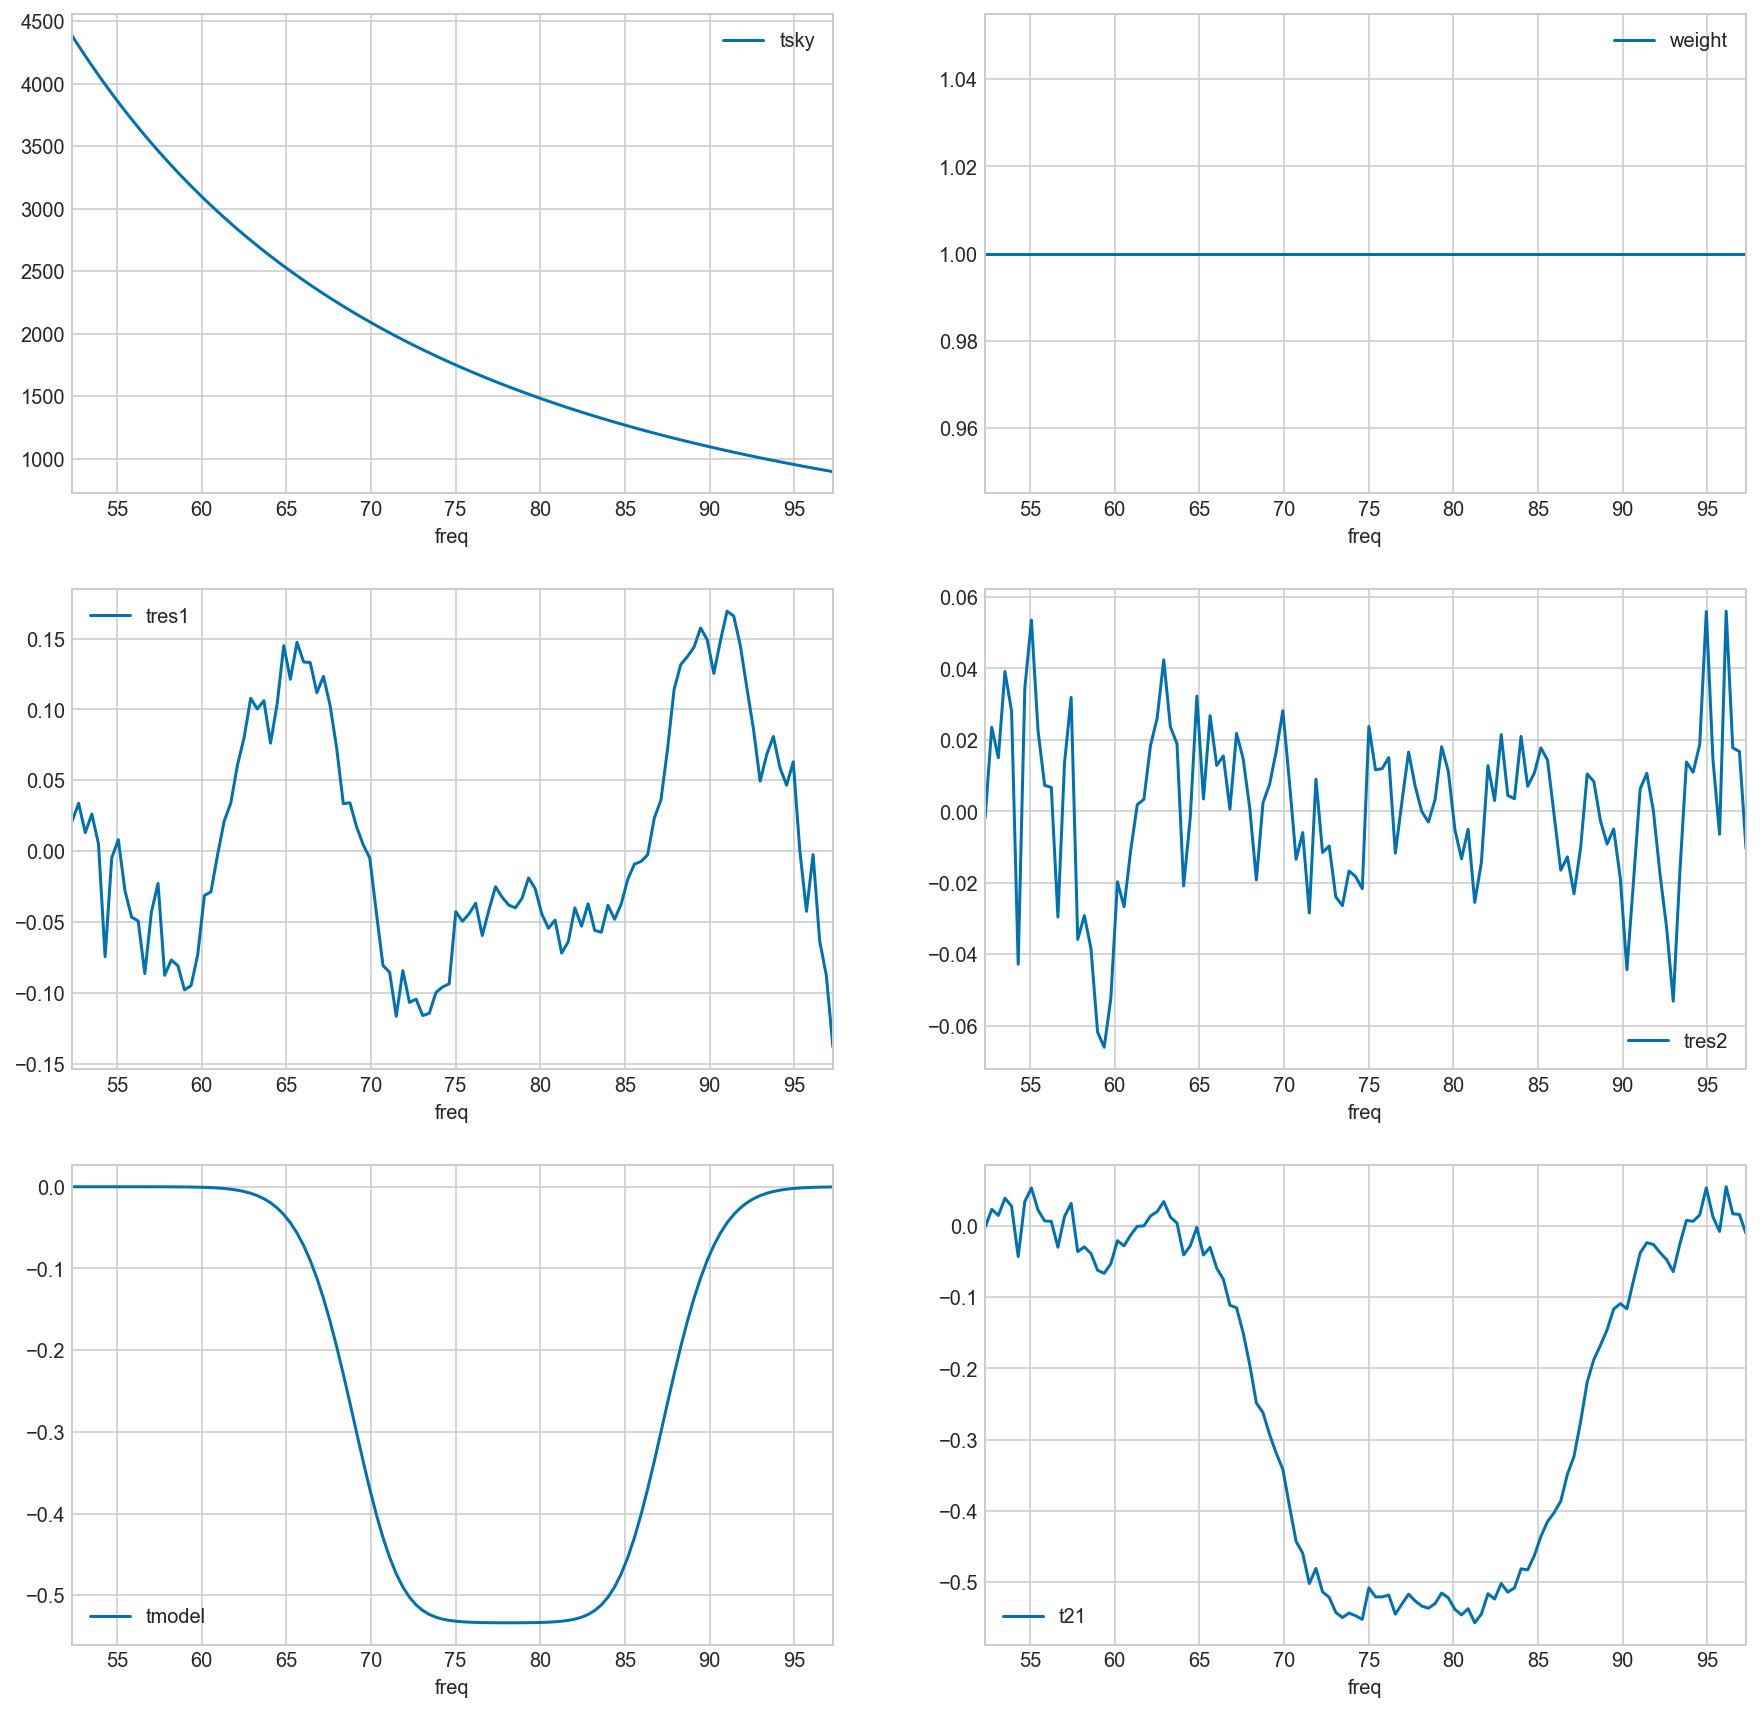

In [6]:
fig, axes = plt.subplots(figsize=(15, 15), ncols=2, nrows=3)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

raw_figure1.plot('freq', 'tsky', ax=ax1)
raw_figure1.plot('freq', 'weight', ax=ax2)
raw_figure1.plot('freq', 'tres1', ax=ax3)
raw_figure1.plot('freq', 'tres2', ax=ax4)
raw_figure1.plot('freq', 'tmodel', ax=ax5)
raw_figure1.plot('freq', 't21', ax=ax6)

Creating a quick interactive bokeh plot to zoom in on the first panel ($T_{\rm sky}$). Interestingly, I can't even zoom in far enough to any features, but that's likely the plotting library's fault.

In [8]:
output_notebook()
p = figure(
  plot_width=800, plot_height=500,
  x_range=[50, 100],
  title='T_sky',
  x_axis_type='linear',
  y_axis_type='linear',
  x_axis_label='Frequency [MHz]',
  y_axis_label='T_sky [K]')

p.line(
    raw_figure1['freq'], raw_figure1['tsky'],
    line_width=1, legend='T_sky', color='black')

show(p)

Loading BokehJS ...

# Re-do the model

## Physically motivated foreground model

In [36]:
p0 = np.full(5, 1., dtype=np.float64)

p_phys, cov_phys = curve_fit(
    f=models.model_fg_phys,
    xdata=raw_figure1['freq'].values,
    ydata=raw_figure1['tsky'].values,
    p0=p0,
    sigma=None)
p_phys

array([-16965.25928092,  -8938.60772476,  -2805.24567829,    216.50318227,
        18499.01807727])

In [38]:
t_sky_model = models.model_fg_phys(
    raw_figure1['freq'].values,
    *p_phys)

Inspect the fit results

In [39]:
output_notebook()
p = figure(
  plot_width=800, plot_height=500,
  x_range=[50, 100],
  title='T_sky',
  x_axis_type='linear',
  y_axis_type='linear',
  x_axis_label='Frequency [MHz]',
  y_axis_label='T_sky [K]')

# Input data
p.line(
    raw_figure1['freq'], raw_figure1['tsky'],
    line_width=1, legend='Input T_sky', color='black')

# Model
p.line(
    raw_figure1['freq'], 1.1 * t_sky_model,
    line_width=1, legend='1.1 x Modeled T_sky', color='blue')

show(p)

Loading BokehJS ...

Residual

In [41]:
output_notebook()
p = figure(
  plot_width=800, plot_height=500,
  x_range=[50, 100],
  title='T_sky',
  x_axis_type='linear',
  y_axis_type='linear',
  y_range=[-0.25, 0.25],
  x_axis_label='Frequency [MHz]',
  y_axis_label='Delta T_sky [K]')

# Model
p.line(
    raw_figure1['freq'], raw_figure1['tsky'] - t_sky_model,
    line_width=1, legend='Data - model', color='black')

show(p)

Loading BokehJS ...

## Set up the trough

In [43]:
p0_trough = np.array([0.5, 78., 6., 10.], dtype=np.float64)
t21_initial = models.model_hi_trough(raw_figure1['freq'].values, *p0_trough)

Quick inspection of the HI trough for sensible initial parameters

In [44]:
output_notebook()
p = figure(
  plot_width=800, plot_height=500,
  x_range=[50, 100],
  title='HI trough',
  x_axis_type='linear',
  y_axis_type='linear',
#   y_range=[-0.25, 0.25],
  x_axis_label='Frequency [MHz]',
  y_axis_label='HI signal [K]')

# Model
p.line(
    raw_figure1['freq'][10:-10], t21_initial,
    line_width=1, legend='T21 initial guess', color='black')

show(p)

Loading BokehJS ...

/Users/dlenz/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 96), ('y', 116)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


## Fit a joint foreground + 21cm model

Running the fit

In [48]:
p0_combined = np.concatenate((p_phys, p0_trough))

p_full, cov_full = curve_fit(
    f=models.fg_phys_plus_21cm,
    xdata=raw_figure1['freq'].values,
    ydata=raw_figure1['tsky'].values,
    p0=p0_combined,
    sigma=None)

t_sky_full = models.fg_phys_plus_21cm(raw_figure1['freq'].values, *p_full)

p_full

array([-1.09189004e+04, -6.05309574e+03, -1.95126828e+03,  1.60495415e+02,
        1.25091494e+04,  5.37565955e-01,  7.81813030e+01,  7.01412494e+00,
        1.87060209e+01])

In [49]:
output_notebook()
p = figure(
  plot_width=800, plot_height=500,
  x_range=[50, 100],
  title='T_sky',
  x_axis_type='linear',
  y_axis_type='linear',
  y_range=[-0.25, 0.25],
  x_axis_label='Frequency [MHz]',
  y_axis_label='Delta T_sky [K]')

# Model
p.line(
    raw_figure1['freq'], raw_figure1['tsky'] - t_sky_full,
    line_width=1, legend='Data - full model', color='black')

show(p)

Loading BokehJS ...

In [51]:
t21_model = models.model_hi_trough(raw_figure1['freq'].values, *p_full[-4:])

In [52]:
output_notebook()
p = figure(
  plot_width=800, plot_height=500,
  x_range=[50, 100],
  title='HI trough',
  x_axis_type='linear',
  y_axis_type='linear',
#   y_range=[-0.25, 0.25],
  x_axis_label='Frequency [MHz]',
  y_axis_label='HI signal [K]')

# Model
p.line(
    raw_figure1['freq'], t21_model,
    line_width=1, legend='T21 model', color='black')

# Initial guess
p.line(
    raw_figure1['freq'], t21_initial,
    line_width=1, legend='T21 p0', color='blue')

# Model + Noise
p.line(
    raw_figure1['freq'], t21_model + raw_figure1['tsky'] - t_sky_full,
    line_width=1, legend='T21 model + residual', color='red')

p.legend.location = 'bottom_left'

show(p)

Loading BokehJS ...

# Set up an MCMC analysis of the full model

## Define posterior

In [ ]:
def get_posterior(freqs, tsky):
  """
  Returns the callable ln_posterior that can then be passed to a sampler. This
  ln_posterior takes a list of parameters as input.
  
  Parameters
  ----------
  
  freqs : 1D array, double
    Frequencies in MHz
    
  tsky : 1D array, double, same shape as freqs
    Total sky temperature
    
  Returns
  -------
  
  ln_posterior : function
    Callable function that takes a sequence of parameters as input and returns
    the log-posterior
  """

  def ln_posterior(params):
    pr = ln_prior(params)
    if not np.isfinite(pr):
      return np.inf
    else:
      return pr + ln_like(params)

  def ln_like(params):
    """Urgh, someone write down the analytical log likelihood please.
    """
    a0, a1, a2, a3, a4, = params[:5]
    amp, nu_0, tau, w = parameters[5:9]
    sigma = parameters[-1]
    
    fg_plus_21cm(nus, *parameters)
    
    like_value = -np.log()

    
  def ln_prior(params):
    """
    Prior
    """
    a0, a1, a2, a3, a4, = params[:5]
    amp, nu_0, tau, w = parameters[5:9]
    sigma = parameters[-1]
    
    if sigma < 0.:
      return -np.inf
    
    if amp < 0.:
      return -np.inf
    
    if (nu_0 < 30.) or (nu_0 > 120.):
      return -np.inf
    
    if tau < 0.:
      return -np.inf
    
    if w < 0.:
      return -np.inf
    
  return ln_posterior

SyntaxError: ignored

## Initiate the ln posterior

In [ ]:
ln_posterior = get_posterior(
  freqs=raw_figure1['freq'].values,
  tsky=raw_figure1['tsky'].values)

## Initial estimate
Using `scipy.minimize` to determine the MAP

In [ ]:
p_map = minimize(
    lambda p: -1. * ln_posterior,
    x0=p_full,
    method='Nelder-Mead',
    bounds=None,)

## Initiate sampler

In [ ]:
ndim = p_full.shape[0]
nwalkers = 100
nsteps = 1000

In [ ]:
# We initialize the differenet walkers with the MAP estimate,
# randomized by +- 10 percent.

p0_emcee = np.random.uniform(low=0.9, high=1.1, size=(ndim, nwalkers)) * p_full[:, None]
p0_emcee.shape

(9, 100)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior)

## Run sampler

In [ ]:
sampler.run_mcmc(p0_emcee, nsteps)

## Plot samples

In [ ]:
# Code up a function that plots random samples of our fit

## Plot triangle

In [ ]:
corner(
    sampler.flatchain,
    labels=[
        r"$a_0$",
        r"$a_1$",
        r"$a_2$",
        r"$a_3$",
        r"$a_4$",
        r"$\rm amp$",
        r"$\nu_0$",
        r"$\tau$",
        r"$w$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True)